# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow those simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 4th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

In the exercises below, I describe the exercises in a general way. Drawing in the right parts of the exercises is part of the assignment. (That way we're helping you get a little bit more ready for the Final Project, where you have to decide what information to include in your report and analysis). 

# Part 1: Analyze the network

The questions in this part are based on Lecture 5.

* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   - I would like you to include concepts like centrality and assortativity in your analysis.
   - Use a network backbone in your analysis.
   - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   - **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network. 

## Loading the network of rock performance

The goal of this section is to build a directed network of rock performers based on Wikipedia data.

Each .pkl file in the dataset represents one performer and contains the raw wikitext of their Wikipedia page.

The task is to extract links between these pages and represent them as directed edges between nodes in a graph.

### Initialize and locate data files

The code below imports the necessary packages and loads all .pkl files from the dataset folder data/rock_performers/.

Each file name is used to identify a performer in the network.

In [1]:
# Visualize the network using NetworkX.
import networkx as nx
import os
import re
import pickle
import copy
import numpy as np
import matplotlib.pyplot as plt


G = nx.DiGraph()
directory = "data/rock_performers/"
all_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".pkl")]
all_performers = [os.path.splitext(os.path.basename(f))[0] for f in all_paths]
performer_set = set(all_performers)
links_collection = {}

This initializes an empty directed graph G, identifies all performer files, and prepares to collect hyperlinks between them.

### Extract valid Wikipedia links

Each performer’s .pkl file is opened and scanned for internal Wikipedia links using a regular expression.

Only links referring to other known performers are retained.

Irrelevant links, such as images or category pages, are ignored.

In [2]:
for file_path in all_paths:
    performer = os.path.splitext(os.path.basename(file_path))[0]
    
    # Load pickled page
    with open(file_path, "rb") as f:
        wikitext = pickle.load(f)

    # Extract all wiki links
    all_links = re.findall(r"\[\[(.*?)\]\]", wikitext)

    filtered_links = []
    for link in all_links:
        # Skip non-people links
        if any(x in link for x in ["File", "Image", "Special", "Category", "rock music"]):
            continue
        
        # Take the displayed name if there is a pipe
        clean_link = re.split(r'\|', link)[-1]
        clean_link = clean_link.replace(" ", "_")

        # Only keep links to known performers and avoid self-loops
        if clean_link != performer and clean_link in performer_set:
            filtered_links.append(clean_link)

    links_collection[performer] = filtered_links

This produces a dictionary called links_collection, where each performer maps to a list of other performers that their page links to.

### Clean performer names

Wikipedia titles often contain characters that can break filenames or URLs.

The next step standardizes performer names by removing invalid characters and replacing spaces with underscores.

In [3]:
def clean_name(name):
    return re.sub(r'[\\/*?:"<>|]', "_", name).replace(" ", "_")

all_performers = [clean_name(os.path.splitext(os.path.basename(f))[0]) for f in all_paths]
performer_set = set(all_performers)

This ensures all node names are formatted consistently throughout the graph.

### Rebuild the link structure

After cleaning, all links are processed again so that each performer only connects to other valid performers in the dataset.

In [4]:
matching_links_collection = {}

for file_path in all_paths:
    performer = clean_name(os.path.splitext(os.path.basename(file_path))[0])
    
    with open(file_path, "rb") as f:
        wikitext = pickle.load(f)

    all_links = re.findall(r"\[\[(.*?)\]\]", wikitext)
    filtered_links = []

    for link in all_links:
        if any(x in link for x in ["File", "Image", "Special", "Category", "rock music"]):
            continue
        
        clean_link = clean_name(re.split(r'\|', link)[-1])
        if clean_link != performer and clean_link in performer_set:
            filtered_links.append(clean_link)
    
    matching_links_collection[performer] = filtered_links

This step ensures that each connection in the network is both valid and consistent with the cleaned naming convention.

### Build the directed graph

Each performer becomes a node in the graph.

The code also counts the total number of words on each page and stores that as a node attribute (`length_of_content`), which later serves as a measure of page size or importance.

The edges are created for each valid hyperlink.

In [5]:
for performer in all_performers:
    # Build the path to the correct file for this performer
    file_path = os.path.join(directory, f"{performer}.pkl")
    
    with open(file_path, "rb") as f:
        text = pickle.load(f)
        length_of_content = len(text.split())  # simpler and more accurate word count

    # Add performer node with word_count attribute
    G.add_node(performer, length_of_content=length_of_content, word_count=length_of_content)

    # Add edges to linked performers
    for target in matching_links_collection.get(performer, []):
        G.add_edge(performer, target)

Each directed edge indicates a hyperlink from one performer’s Wikipedia page to another performer’s page.

### Remove isolated nodes

Finally, any performer who has neither incoming nor outgoing links is removed.
This leaves only the connected portion of the network for analysis.

In [6]:
# Final clean ups:
isolated = list(nx.isolates(G))

G.remove_nodes_from(isolated)

After running the above steps, a clean directed graph is constructed.
It represents the network of rock performers and the hyperlinks connecting their Wikipedia pages.

Each node corresponds to one performer and includes a `length_of_content` attribute indicating the size of their Wikipedia entry.

This network have now the foundation for all further analysis which including the degree distributions, centrality measures and assortativity.

Before that, the network will be visualized.

## Visualize the graph of the network

This section focuses on visualizing the main connected component of the rock-performer network to provide an overview of its structural properties.

The network is first converted from a directed graph to an undirected graph to simplify the visualization and emphasize general connectivity rather than directionality.

It is only the Giant Connected Component (`GCC`) is used, as it represents the largest group of performers that are all reachable from one another, ensuring the visualization reflects the primary structure of the network rather than small isolated fragments.

The node size is proportional to each performer’s degree (number of unique connections), and the node color corresponds to the length of the performer’s Wikipedia page (`length_of_content`).

This combination provides a simultaneous view of both connectivity and documentation. The larger, the darker nodes, this indicate the artists who are both highly connected and have extensive Wikipedia coverage.

In [7]:
# Always build an undirected Giant Connected Component (GCC) once
G_ud = G.to_undirected()
gcc_nodes = max(nx.connected_components(G_ud), key=len)
G_ud_gcc = G_ud.subgraph(gcc_nodes).copy()
print(f"GCC: {G_ud_gcc.number_of_nodes()} nodes, {G_ud_gcc.number_of_edges()} edges")

GCC: 578 nodes, 6356 edges


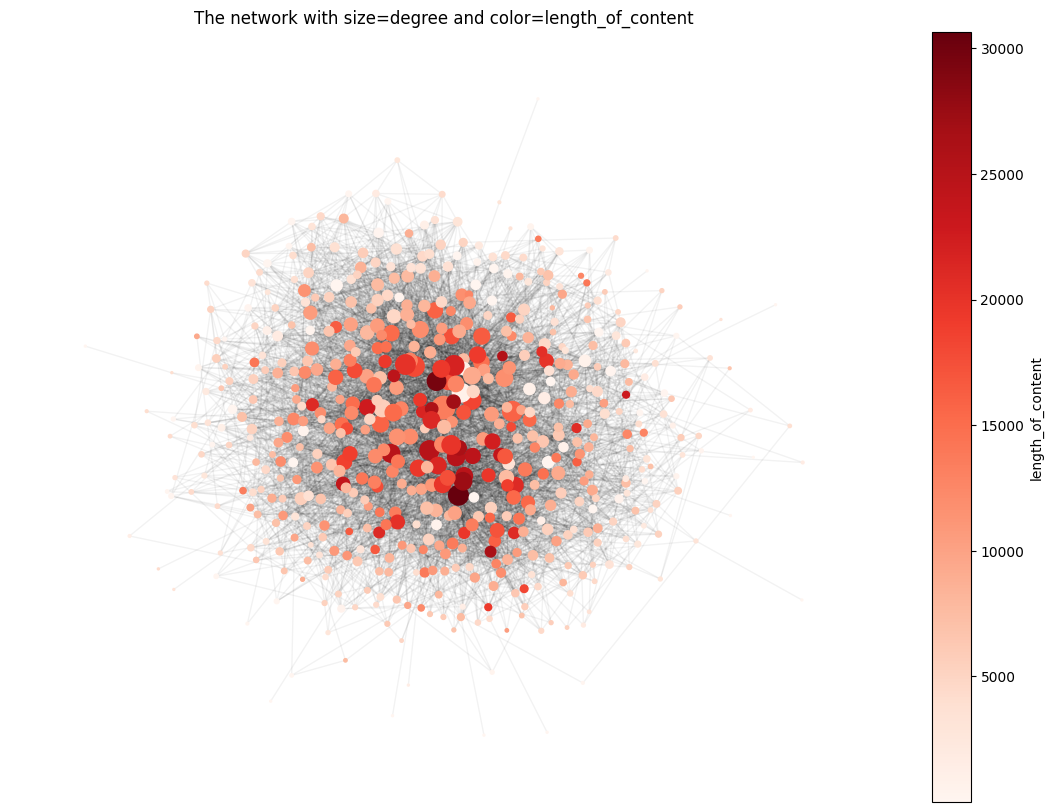

In [8]:
deg_ud = dict(G_ud_gcc.degree())
sizes = np.array([deg_ud[n] for n in G_ud_gcc]) * 2.0
colors = np.array([G_ud_gcc.nodes[n]['length_of_content'] for n in G_ud_gcc])

try:
    pos = nx.forceatlas2_layout(G_ud_gcc, iterations=2000, adjustSizes=True, barnesHutOptimize=True)
except Exception:
    pos = nx.kamada_kawai_layout(G_ud_gcc)

plt.figure(figsize=(14,10))
nx.draw_networkx_edges(G_ud_gcc, pos, alpha=0.05)
h = nx.draw_networkx_nodes(G_ud_gcc, pos, node_size=sizes, node_color=colors, cmap=plt.cm.Reds)
plt.colorbar(h, label='length_of_content')
plt.axis('off'); plt.title('The network with size=degree and color=length_of_content')
plt.show()

The visualization reveals a dense, interconnected core surrounded by a sparser periphery.

The larger nodes tend to cluster near the center, which indicating the performers with the highest degree of connectivity. These central performers likely correspond to influential or widely recognized artists who are referenced frequently across other performer pages.

The smaller and lighter nodes are positioned around the edges, representing less connected or more niche performers.

The color distribution suggests a moderate correlation between the size of the performer’s page and network centrality—performers with longer Wikipedia entries often appear larger and more central in the layout.

## Degrees Analysis

The next step in the analysis focuses on understanding how connections are distributed across the network by measuring the `in-degree`, `out-degree`, and the `total_degree` for each performer.

Since this network is directed, the `in-degree` of a node represents how many other performers link to that artist’s Wikipedia page, while the `out-degree` represents how many pages that artist’s page links to.

The following code calculates these metrics and identifies the top $10$ artists with the highest `in-degree` and `out-degree`, followed by two bar charts visualizing the top $15$ performers in each category.

In [9]:
nodes = list(G.nodes())

in_degrees  = dict(G.in_degree())
out_degrees = dict(G.out_degree())
tot_degrees = dict(G.degree())

top_in  = sorted(in_degrees.items(),  key=lambda x: x[1], reverse=True)[:10]
top_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

In [10]:
print("Top-10 by IN-degree:")
for n,k in top_in:  print(f"{n:40s} in={k:4d} out={out_degrees.get(n,0):4d}")

Top-10 by IN-degree:
Led_Zeppelin                             in= 118 out=  28
Bob_Dylan                                in=  94 out=  30
Queen                                    in=  87 out=   1
David_Bowie                              in=  82 out=  22
Metallica                                in=  80 out=  45
Jimi_Hendrix                             in=  75 out=  30
U2                                       in=  74 out=  14
Nirvana                                  in=  72 out=   0
Black_Sabbath                            in=  69 out=  57
John_Lennon                              in=  68 out=  14


The `in-degree` ranking highlights the performers who are referenced by many others. The effectively, artists with widespread recognition and cultural impact like Led Zeppelin, Bob Dylan, David Bowie, and The Beatles-related members (John Lennon) dominate this list. 

These are iconic figures who have influenced large portions of the rock genre, and their high `in-degree` reflects that many performer pages link to them as references or influences.

In [11]:
print("\nTop-10 by OUT-degree:")
for n,k in top_out: print(f"{n:40s} out={k:4d} in={in_degrees.get(n,0):4d}")


Top-10 by OUT-degree:
Alice_in_Chains                          out=  73 in=  49
Deep_Purple                              out=  69 in=  49
Black_Sabbath                            out=  57 in=  69
Def_Leppard                              out=  48 in=  37
Bryan_Adams                              out=  48 in=  15
Guns_N'_Roses                            out=  47 in=  60
Rush_(band)                              out=  47 in=   1
Metallica                                out=  45 in=  80
Queen_(band)                             out=  45 in=   1
Alice_Cooper                             out=  41 in=  55


The `out-degree` ranking emphasizes pages that link to many others, such as Alice in Chains, Deep Purple, and Def Leppard have extensive pages with numerous internal references, likely due to rich histories of collaborations, changing band members, and participation in multiple side projects.

Some entries (e.g., Rush_(band) or Queen_(band)) may represent disambiguated Wikipedia titles that differ from the main artist page, which can explain the mismatch between similar names like Queen and Queen_(band).

Several artists, such as Metallica and Black Sabbath, appear on both lists, indicating that they are both highly referenced and extensively connected to others which indicates a core hubs within the network.

The bar plots below visualize the top $15$ performers ranked by `in-degree` and `out-degree`.

Each bar represents the number of hyperlinks associated with a performer, allowing a quick visual comparison of how connectivity is distributed among the most central nodes in the network.

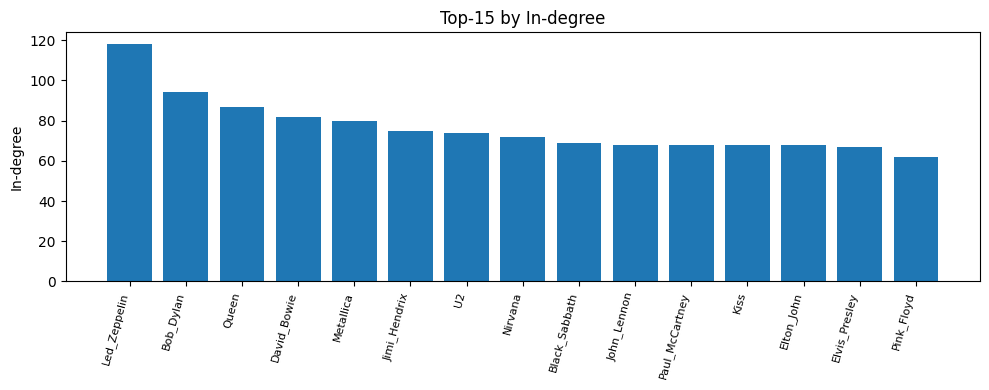

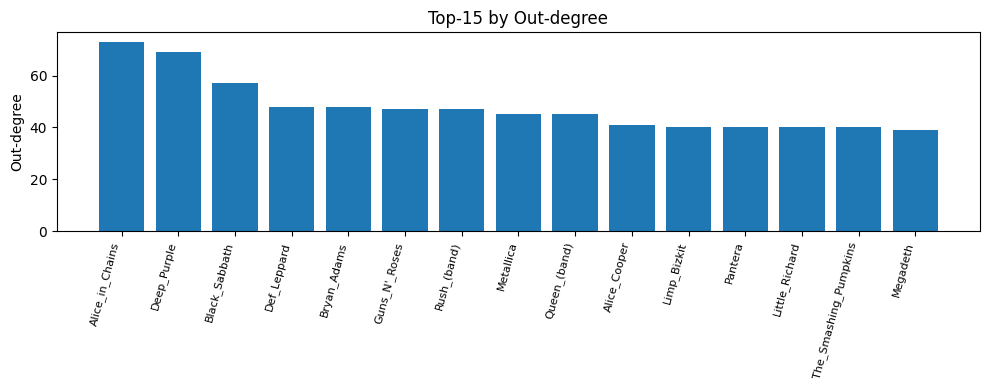

In [12]:
labels_in, vals_in = zip(*sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:15])
plt.figure(figsize=(10,4))
plt.bar(range(len(vals_in)), vals_in)
plt.xticks(range(len(vals_in)), labels_in, rotation=75, ha='right', fontsize=8)
plt.ylabel("In-degree"); plt.title("Top-15 by In-degree")
plt.tight_layout(); plt.show()

# Bar chart for top-15 OUT-degree
labels_out, vals_out = zip(*sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:15])
plt.figure(figsize=(10,4))
plt.bar(range(len(vals_out)), vals_out)
plt.xticks(range(len(vals_out)), labels_out, rotation=75, ha='right', fontsize=8)
plt.ylabel("Out-degree"); plt.title("Top-15 by Out-degree")
plt.tight_layout(); plt.show()

The `in-degree` plot shows that a small number of artists, most notably Led Zeppelin, Bob Dylan, Queen, and David Bowie—receive a disproportionately high number of incoming links.\
This pattern confirms that these performers serve as core performers within the network. 

The `out-degree` plot reveals that certain bands, such as Alice in Chains, Deep Purple, and Def Leppard that are link to an unusually high number of other performers.\
This often occurs for groups with complex histories involving frequent member changes, collaborations, and participation in other musical projects.\ 
It suggests that their Wikipedia pages include numerous cross-references to related artists, creating dense local connections.

## Centrality measures

This section focuses on identifying the most influential and structurally important performers in the network using three different centrality measures which is `degree centrality`, `betweenness centrality`, and `eigenvector centrality`. 

These measures capture different aspects of importance within the network and are used to understand both the popularity and structural roles of nodes. All calculations are made on the undirected giant connected component to ensure that the analysis reflects the core structure of the network and excludes isolated or peripheral nodes.

In [13]:
# Use the undirected GCC you already made:
G_undirected = G_ud_gcc

In [14]:
# Degree centrality
deg_centrality = nx.degree_centrality(G_undirected)
top_degree = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 by Degree Centrality:")
for n, c in top_degree:
    print(f"{n:40s}  centrality={c:.3f}")

Top 5 by Degree Centrality:
Led_Zeppelin                              centrality=0.229
Metallica                                 centrality=0.175
Black_Sabbath                             centrality=0.173
Deep_Purple                               centrality=0.172
Bob_Dylan                                 centrality=0.172


The `degree centrality` measures how many direct connections each performer has and the values indicate how connected each performer is within the network.

Led Zeppelin has the highest `degree centrality` of $0.229$, which meas that it connects directly to about $23\%$ of all other nodes.
Metallica, Black Sabbath, Deep Purple, and Bob Dylan follow closely, each links to around $17\%$ of all performers.

These scores show that the network’s structure is dominated by a small group of core performers with extensive connections, reflecting their central influence in the rock genre.
The small drop between Led Zeppelin and the others suggests several highly connected hubs rather than a single dominant one.

In [15]:
# Betweenness centrality
bet_centrality = nx.betweenness_centrality(G_undirected)
top_bet = sorted(bet_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 by Betweenness Centrality:")
for n, c in top_bet:
    print(f"{n:40s}  centrality={c:.3f}")


Top 5 by Betweenness Centrality:
Led_Zeppelin                              centrality=0.048
Deep_Purple                               centrality=0.036
Bob_Dylan                                 centrality=0.035
Jimi_Hendrix                              centrality=0.029
Alice_in_Chains                           centrality=0.028


The `betweenness centrality` identifies nodes that act as bridges between different parts of the network. 

Led Zeppelin again ranks highest, reinforcing its role as a central bridge between various clusters of artists. Deep Purple and Bob Dylan also hold key structural positions, linking otherwise separate communities within the rock landscape.

The relatively small differences in values suggest that several artists share comparable bridging roles, but Led Zeppelin clearly dominates the flow of connections across the network.

In [16]:
# Eigenvector centrality
eig_centrality = nx.eigenvector_centrality(G_undirected)
top_eig = sorted(eig_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 by Eigenvector Centrality:")
for n, c in top_eig:
    print(f"{n:40s}  centrality={c:.3f}")


Top 5 by Eigenvector Centrality:
Led_Zeppelin                              centrality=0.181
Metallica                                 centrality=0.160
Black_Sabbath                             centrality=0.157
Alice_in_Chains                           centrality=0.152
Deep_Purple                               centrality=0.144


The `eigenvector centrality` identifies performers who are not just well-connected, but connected to other influential artists. Led Zeppelin again ranks first, suggesting it sits at the heart of the most prominent subnetwork of rock performers. Metallica, Black Sabbath, and Deep Purple also appear, showing that they belong to the same influential core.

The small differences in centrality scores indicate a tightly knit elite cluster of bands that reinforce each other’s prominence within the network.

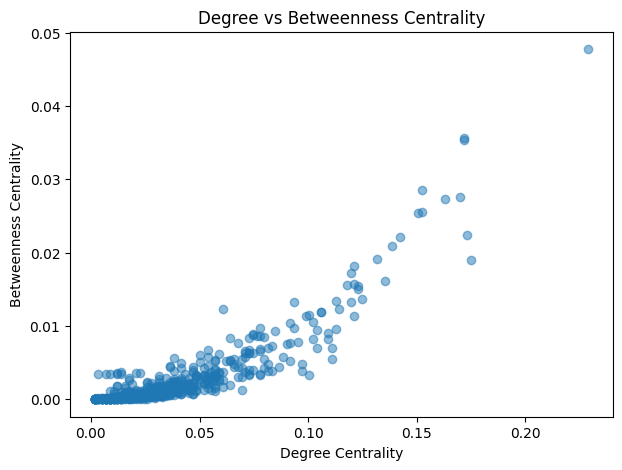

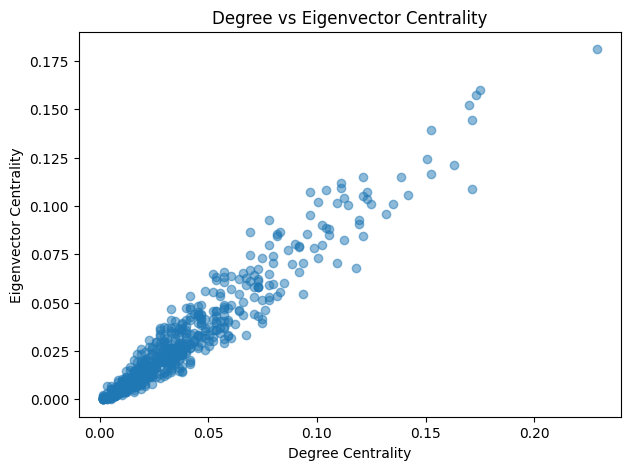

In [17]:
# Degree vs Betweenness
plt.figure(figsize=(7,5))
plt.scatter(list(deg_centrality.values()), list(bet_centrality.values()), alpha=0.5)
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Degree vs Betweenness Centrality")
plt.show()

# Degree vs Eigenvector
plt.figure(figsize=(7,5))
plt.scatter(list(deg_centrality.values()), list(eig_centrality.values()), alpha=0.5)
plt.xlabel("Degree Centrality")
plt.ylabel("Eigenvector Centrality")
plt.title("Degree vs Eigenvector Centrality")
plt.show()

The two scatter plots illustrate the relationship between these measures. The first plot compares `degree centrality` and `betweenness centrality`. A general positive trend is observed which means that the nodes with many links tend to also act as bridges though some exceptions exist.

The second plot compares `degree centrality` and `eigenvector centrality`. This relationship is more consistent, showing that highly connected nodes also tend to be embedded within other influential clusters.

Overall, the three centrality measures complement each other. Together, they reveal a nuanced structure of influence in the rock performer network, distinguishing widely connected hubs from strategic intermediaries and deeply embedded icons.

## Assortativity

The assortativity analysis evaluates whether similar nodes in the rock performer network tend to connect. Two types are measured, which is the `degree assortativity`, showing whether highly connected artists link with each other, and `attribute assortativity`, based on Wikipedia page length.

In [18]:
# DEGREE ASSORTATIVITY
assort_degree = nx.degree_pearson_correlation_coefficient(G_undirected)
print("Degree assortativity:", assort_degree)

# ATTRIBUTE ASSORTATIVITY (based on length_of_content)
assort_length = nx.numeric_assortativity_coefficient(G_undirected, 'length_of_content')
print("Length-of-content assortativity:", assort_length)

Degree assortativity: 0.007632226743081116
Length-of-content assortativity: 0.06026322871251401


The results show very low values on $\text{degree} \approx 0.0076$, and $\text{length\_of\_content} \approx 0.0603$, which indicate that the network is weakly disassortative. This means that the popular or well-connected artists tend to link with smaller, less connected ones rather than with other major hubs. The `length_of_content` assortativity being close to zero which menas that the page size has little impact on who connects to whom.

In short, the rock performer network lacks strong assortative patterns—connections appear driven more by musical or historical relationships than by fame or documentation level.

## Simple backbone extraction

In [28]:
weighted_g1 = copy.deepcopy(G_undirected)

# Now to add edge weights proportional to the edge betweenness centrality, where lowest weight = 1 and highest = 10:
edge_betweenness = nx.edge_betweenness_centrality(weighted_g1)
bet_values = list(edge_betweenness.values())
bet_min = min(bet_values)
bet_max = max(bet_values)

for (u, v), bet in edge_betweenness.items():
    # Normalize betweenness to range 1-10
    normalized_weight = 1 + 99 * (bet - bet_min) / (bet_max - bet_min)
    weighted_g1[u][v]['weight'] = normalized_weight

# Check weights:
list(weighted_g1.edges(data=True))[:5]

[('Oasis', 'Ozzy_Osbourne', {'weight': 8.910972737132127}),
 ('Oasis', 'Sex_Pistols', {'weight': 4.820808986537613}),
 ('Oasis', "Guns_N'_Roses", {'weight': 10.579061024430596}),
 ('Oasis', 'Green_Day', {'weight': 5.316853458393984}),
 ('Oasis', 'Morrissey', {'weight': 3.4418830514274408})]

In [26]:
weighted_g2 = copy.deepcopy(G_undirected)

# Now edge weights are 1/(edge weight in Weighted Network 1):
for u, v, data in weighted_g1.edges(data=True):
    weight = data['weight']
    weighted_g2[u][v]['weight'] = 1 / weight

# Check weights:
list(weighted_g2.edges(data=True))[:5]

[('Oasis', 'Ozzy_Osbourne', {'weight': 0.11222119397055143}),
 ('Oasis', 'Sex_Pistols', {'weight': 0.20743406403210699}),
 ('Oasis', "Guns_N'_Roses", {'weight': 0.09452634763053781}),
 ('Oasis', 'Green_Day', {'weight': 0.18808116639386585}),
 ('Oasis', 'Morrissey', {'weight': 0.29053863395657015})]

In [ ]:
import backboning

alpha_value = 0.005

edges_g1 = nx.to_pandas_edgelist(weighted_g1)
edges_g1.rename(columns={"source": "src", "target": "trg", "weight": "nij"}, inplace=True)
df_scored_g1 = backboning.disparity_filter(edges_g1, undirected=True)

df_backbone_g1 = backboning.thresholding(df_scored_g1, threshold=alpha_value)

edges_g2 = nx.to_pandas_edgelist(weighted_g2)
edges_g2.rename(columns={"source": "src", "target": "trg", "weight": "nij"}, inplace=True)
df_scored_g2 = backboning.disparity_filter(edges_g2, undirected=True)

df_backbone_g2 = backboning.thresholding(df_scored_g2, threshold=alpha_value)

backbone_g1 = nx.from_pandas_edgelist(df_backbone_g1, "src", "trg", ["nij", "score"])
backbone_g2 = nx.from_pandas_edgelist(df_backbone_g2, "src", "trg", ["nij", "score"])

In [ ]:
edges_g1 = nx.to_pandas_edgelist(weighted_g1)
edges_g1.rename(columns={"source": "src", "target": "trg", "weight": "nij"}, inplace=True)
df_backbone_g3 = backboning.high_salience_skeleton(edges_g1, undirected=True)
backbone_g3 = nx.from_pandas_edgelist(df_backbone_g3, "src", "trg", ["nij", "score"])

In [36]:
def plot_backbone(G_backbone, title="Backbone"):
    pos = nx.forceatlas2_layout(G_backbone)

    # Node sizes = degree:
    degrees = dict(G_backbone.degree())
    node_sizes = [degrees[n]*20 for n in G_backbone.nodes()]

    # Draw
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G_backbone, pos, node_size=node_sizes, alpha=0.5)
    nx.draw_networkx_edges(G_backbone, pos, alpha=0.2)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
# Plot all three backbones
plot_backbone(backbone_g1, "Backbone - Weighted network 1 (disparity)")
plot_backbone(backbone_g2, "Backbone - Weighted network 2 (disparity)")
plot_backbone(backbone_g3, "Backbone - Weighted network 3 (HSS)")

# Part 2: Genres and communities and plotting 

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

# Part 3: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?